In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error

In [2]:
df_train = pd.read_csv('/root/tempfile/train_final191219.csv')
df_test = pd.read_csv('/root/tempfile/test_final191219.csv')

In [3]:
print(df_train.shape, df_test.shape)

(201917, 106) (123623, 104)


In [4]:

feature_col = [x for x in train_df.columns if x not in ['card_id','target', 'outliers']]
y_train = train_df.target.values.astype('float')
x_train = train_df[feature_col].values.astype('float')
x_test = test_df[feature_col].values.astype('float')

testindex = test_df.card_id
del train_df, test_df


In [5]:
def regression_cv(param, data, cv):
    score = lgb.cv( 
        param, 
        data, 
        nfold=cv,
        stratified=False, 
        shuffle=True,
        metrics='rmse',
        early_stopping_rounds=50,
        verbose_eval=False, 
        show_stdv=False)
    return score['rmse-mean'][-1]


def hyperopt_train_test(params):
    global df_train
    
    param = {
        'objective':'regression',
        "boosting": "gbdt",
    }
    param['max_depth'] = int(params['max_depth'])
    param['num_leaves'] = int(params['num_leaves'])
    param['min_data_in_leaf'] = int(params['min_data_in_leaf'])
    param['reg_alpha'] = params['reg_alpha']
    param['reg_lambda'] = params['reg_lambda']
    param['feature_fraction'] = params['feature_fraction']
    
    df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'target', 'outliers']]
    data_train = lgb.Dataset(df_train[df_train_columns], label=df_train['target'])
    return regression_cv(param, data_train, cv=5)


def f(params):
    global best
    score = hyperopt_train_test(params)
    if -score > best:
        best = -score
        print('new best:', -best, params)
    return {'loss': score, 'status': STATUS_OK}

In [6]:
space4rf = {
    'max_depth': hp.quniform('max_depth', 5, 13, 1),
    'num_leaves':hp.quniform('num_leaves', 10, 350, 1),
    'min_data_in_leaf':hp.quniform('min_data_in_leaf', 10, 350, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 0.5),   
    'reg_lambda': hp.uniform('reg_lambda', 0, 0.5),
    'feature_fraction' : hp.uniform('feature_fraction', 0.5, 1)}

best = -15
trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=1000, trials=trials)

print('best:')
print(best)

new best: 3.6594868902423285 {'feature_fraction': 0.7605399640104678, 'max_depth': 10.0, 'min_data_in_leaf': 338.0, 'num_leaves': 261.0, 'reg_alpha': 0.403447762002815, 'reg_lambda': 0.12244910687623989}
new best: 3.658996037508916 {'feature_fraction': 0.5503257516017639, 'max_depth': 8.0, 'min_data_in_leaf': 300.0, 'num_leaves': 131.0, 'reg_alpha': 0.12082629332374684, 'reg_lambda': 0.07921996170038431}
new best: 3.658954082970829 {'feature_fraction': 0.9033794260256631, 'max_depth': 7.0, 'min_data_in_leaf': 313.0, 'num_leaves': 265.0, 'reg_alpha': 0.35132753980099646, 'reg_lambda': 0.33651085966405847}
new best: 3.6580084602033778 {'feature_fraction': 0.6229566400813662, 'max_depth': 6.0, 'min_data_in_leaf': 323.0, 'num_leaves': 115.0, 'reg_alpha': 0.44268090060991155, 'reg_lambda': 0.48822790474864886}
new best: 3.656348666880306 {'feature_fraction': 0.8408479610383566, 'max_depth': 5.0, 'min_data_in_leaf': 259.0, 'num_leaves': 45.0, 'reg_alpha': 0.4950366827340328, 'reg_lambda': 0.

In [6]:
best = {'feature_fraction': 0.8609490852544645, 'max_depth': 6.0, 'min_data_in_leaf': 323.0, 'num_leaves': 240.0, 'reg_alpha': 0.28727372600327195, 'reg_lambda': 0.02607489242405017}

In [7]:
param = {
    'learning_rate':0.01,
    'objective':'regression',
    'metric':'rmse'
}
param = dict(param, **best)
param['max_depth'] = int(param['max_depth'])
param['min_data_in_leaf'] = int(param['min_data_in_leaf'])
param['num_leaves'] = int(param['num_leaves'])

In [9]:
param

{'learning_rate': 0.01,
 'objective': 'regression',
 'metric': 'rmse',
 'feature_fraction': 0.8609490852544645,
 'max_depth': 6,
 'min_data_in_leaf': 323,
 'num_leaves': 240,
 'reg_alpha': 0.28727372600327195,
 'reg_lambda': 0.02607489242405017}

In [8]:
folds = StratifiedKFold(n_splits=20, shuffle=True)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'target', 'outliers']]


for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=df_train['target'][trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=df_train['target'][val_idx])#, categorical_feature=categorical_feats)

    num_round = 20000
    clf = lgb.train(param,
                    trn_data,
                    num_round, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval=1000,
                    early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, df_train['target']))

fold 0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's rmse: 3.55559	valid_1's rmse: 3.67774
[2000]	training's rmse: 3.50354	valid_1's rmse: 3.67635
Early stopping, best iteration is:
[1486]	training's rmse: 3.52897	valid_1's rmse: 3.67531
fold 1
Training until validation scores don't improve for 1000 rounds.
[1000]	training's rmse: 3.55626	valid_1's rmse: 3.65834
[2000]	training's rmse: 3.50141	valid_1's rmse: 3.65653
[3000]	training's rmse: 3.45635	valid_1's rmse: 3.65804
Early stopping, best iteration is:
[2123]	training's rmse: 3.49521	valid_1's rmse: 3.65583
fold 2
Training until validation scores don't improve for 1000 rounds.
[1000]	training's rmse: 3.56037	valid_1's rmse: 3.60687
[2000]	training's rmse: 3.50916	valid_1's rmse: 3.60373
[3000]	training's rmse: 3.46612	valid_1's rmse: 3.60431
Early stopping, best iteration is:
[2575]	training's rmse: 3.48288	valid_1's rmse: 3.60319
fold 3
Training until validation scores don't improve for 1000 rou

3.6498458199865618

/root/anaconda3/envs/jupyter/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


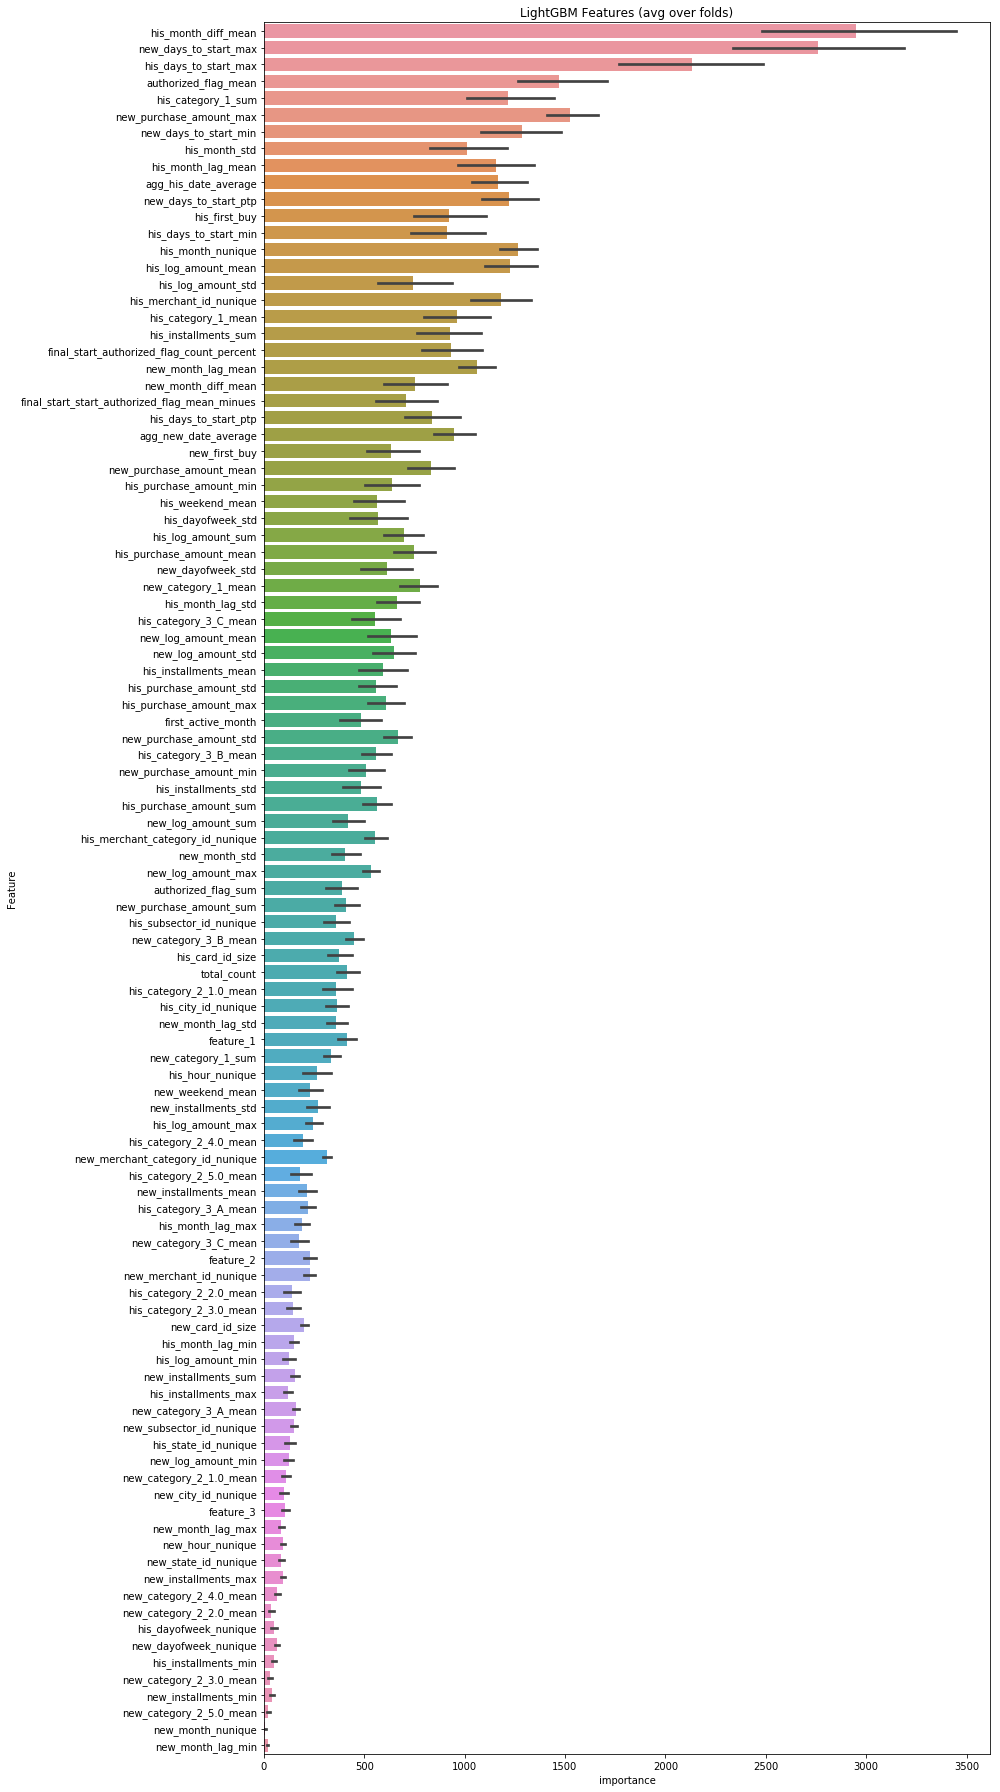

In [10]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [ ]:
df_